In [14]:
from make_data import make_data
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score



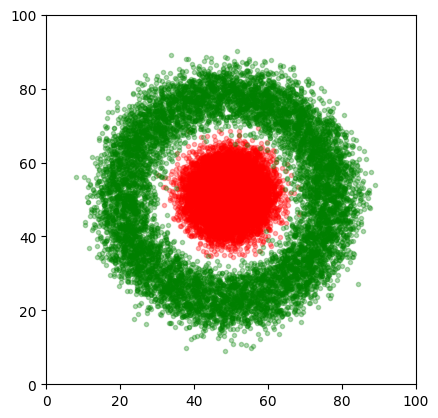

In [15]:
example_nr = 3
n_pts = 10000
noise = 3
X, T, x_grid, dim = make_data(example_nr, n_pts, noise)

fig, ax = plt.subplots()
ax.plot(X[0,T[0]], X[1,T[0]], '.r', alpha=0.3)
ax.plot(X[0,T[1]], X[1,T[1]], '.g', alpha=0.3)
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_box_aspect(1)

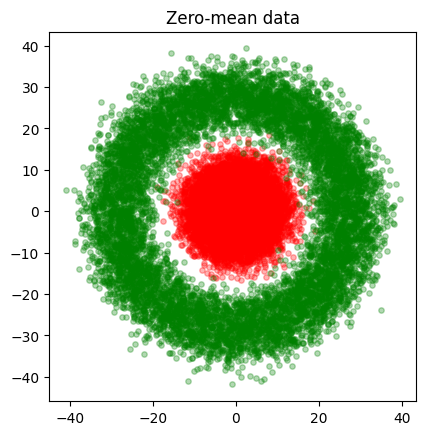

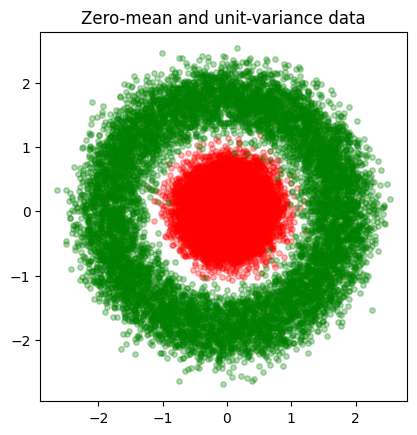

In [16]:
#%% Before training, you should make data zero mean
    
c = np.mean(X, axis=1, keepdims=True)
X_c = X - c

fig, ax = plt.subplots(1,1)
ax.scatter(X_c[0][T[0]], X_c[1][T[0]], c='r', alpha=0.3, s=15)
ax.scatter(X_c[0][T[1]], X_c[1][T[1]], c='g', alpha=0.3, s=15)
ax.set_aspect('equal', 'box')
plt.title('Zero-mean data')
plt.show()

# standard deviation of 1
s = np.std(X_c, axis=1, keepdims=True)
X_c = X_c / s
fig, ax = plt.subplots(1,1)
ax.scatter(X_c[0][T[0]], X_c[1][T[0]], c='r', alpha=0.3, s=15)
ax.scatter(X_c[0][T[1]], X_c[1][T[1]], c='g', alpha=0.3, s=15)
ax.set_aspect('equal', 'box')
plt.title('Zero-mean and unit-variance data')
plt.show()

In [17]:
# Assuming X_c is a 2D array where columns are samples
X_train, X_test, T_train, T_test = train_test_split(X_c.T, T.T, test_size=0.2, random_state=42)  # Transpose to split samples
X_train = X_train.T  # Transpose back to original shape
X_test = X_test.T    # Transpose back to original shape
T_train = T_train.T  # Transpose back to original shape
T_test = T_test.T    # Transpose back to original shape

print("Training data shape:", X_train.shape)
print("Training labels shape:", T_train.shape)
print("Testing data shape:", X_test.shape)
print("Testing labels shape:", T_test.shape)

Training data shape: (2, 14560)
Training labels shape: (2, 14560)
Testing data shape: (2, 3641)
Testing labels shape: (2, 3641)


In [18]:
# Example architecture: 2 input features, 2 hidden layers with 10 and 8 units, and 2 output classes
architecture = [2, 10, 8, 2]  # [input_dim, hidden_layer_1, hidden_layer_2, output_dim]

In [19]:
def initialize_weights_dynamic(architecture):
    """
    Initialize weights for a neural network with a variable number of layers.

    Args:
        architecture (list): List specifying the number of units in each layer.

    Returns:
        weights (list): List of weight matrices for each layer.
    """
    weights = []
    for i in range(len(architecture) - 1):
        # Initialize weights with He initialization
        input_units = architecture[i]
        output_units = architecture[i + 1]
        W = np.random.normal(0, 1, (input_units + 1, output_units)) * np.sqrt(2 / (input_units + 1))
        weights.append(W)
        
    return weights

In [20]:
#architecture = [2, 3, 2] 
weights = initialize_weights_dynamic(architecture)

for i in range(len(weights)):
    print(f"Layer {i} weights shape: {weights[i].shape}")

# architecture = [2, 10, 8, 2]


Layer 0 weights shape: (3, 10)
Layer 1 weights shape: (11, 8)
Layer 2 weights shape: (9, 2)


In [21]:
def forward_pass_dynamic(X, weights):
    """
    Perform a forward pass through a neural network with multiple layers.

    Args:
        X (numpy.ndarray): Input data of shape (input_dim, num_samples).
        weights (list): List of weight matrices for each layer.

    Returns:
        activations (list): List of activations for each layer (including input and hidden layers).
        outputs (numpy.ndarray): Output of the network after softmax activation.
    """
    activations = [np.vstack((X, np.ones((1, X.shape[1]))))]  # Add bias to input and store as the first activation
    for W in weights[:-1]:  # For all layers except the output layer
        z = np.dot(W.T, activations[-1])  # Compute z = W * activations of the previous layer
        h = np.maximum(z, 0)  # Apply ReLU activation
        h = np.vstack((h, np.ones((1, h.shape[1]))))  # Add bias
        activations.append(h)  # Store activations for this layer

    # Output layer
    z = np.dot(weights[-1].T, activations[-1])  # Compute z for the output layer
    e_x = np.exp(z - np.max(z, axis=0))  # Apply softmax activation
    outputs = e_x / e_x.sum(axis=0)  # Normalize to get probabilities
    
    return activations, outputs


In [22]:
W1 = weights[0]  # First layer weights
W2 = weights[1]  # Second layer weights
W3 = weights[2]  # Third layer weights

# Add bias to the input
activations = [np.vstack((X, np.ones((1, X.shape[1]))))]
print('activations: ', activations[0].shape)


for W in weights[:-1]:
    z = np.dot(W.T, activations[-1])
    print('z: ', z.shape)
    h = np.maximum(z, 0)
    print('h: ', h.shape)
    h = np.vstack((h, np.ones((1, h.shape[1]))))
    print('h_ones: ', h.shape)
    activations.append(h)
    print(f'activations[{len(activations) - 1}] shape: ', activations[-1].shape)  # Print the shape of the latest activation

# Output layer
z = np.dot(weights[-1].T, activations[-1])
print(' z output: ', z.shape)
e_x = np.exp(z - np.max(z, axis=0))
outputs = e_x / e_x.sum(axis=0)  # Softmax activation
print('output: ', outputs.shape)

activations:  (3, 18201)
z:  (10, 18201)
h:  (10, 18201)
h_ones:  (11, 18201)
activations[1] shape:  (11, 18201)
z:  (8, 18201)
h:  (8, 18201)
h_ones:  (9, 18201)
activations[2] shape:  (9, 18201)
 z output:  (2, 18201)
output:  (2, 18201)


In [23]:
""" for i in range(len(weights) - 2, -1, -1):  # Iterate from the second-to-last layer to the first
    print(i)
    W_no_bias = weights[i][:-1, :]
    print('W_no_bias: ', W_no_bias.shape)

    h_no_bias = h[i][:-1, :]
    print(f'h_no_bias (layer {i + 1}): ', h_no_bias.shape)

    a = h_no_bias > 0
    print(f'a (ReLU derivative, layer {i + 1}): ', a.shape)

    # Partial derivative for W1
    delta1 = np.dot(W_no_bias, delta2) * a
    print(f'delta1 (layer {i}): ', delta1.shape)

    X_ones = np.vstack((X_c, np.ones((1, X_c.shape[1]))))  # Add bias to input
    q1 = np.dot(X_ones, delta1.T) / X_c.shape[1]  # Average over minibatch

    q1 = np.dot(h[i], delta1.T) / X.shape[1]  # Average over batch
    print(f'q1 (layer {i}): ', q1.shape)

    # Update the weights for the current layer
    weights[i] -= lr * q1
    print(f'Updated weights for layer {i}: ', weights[i].shape)

    # Update delta2 for the next layer
    delta2 = delta1
 """


" for i in range(len(weights) - 2, -1, -1):  # Iterate from the second-to-last layer to the first\n    print(i)\n    W_no_bias = weights[i][:-1, :]\n    print('W_no_bias: ', W_no_bias.shape)\n\n    h_no_bias = h[i][:-1, :]\n    print(f'h_no_bias (layer {i + 1}): ', h_no_bias.shape)\n\n    a = h_no_bias > 0\n    print(f'a (ReLU derivative, layer {i + 1}): ', a.shape)\n\n    # Partial derivative for W1\n    delta1 = np.dot(W_no_bias, delta2) * a\n    print(f'delta1 (layer {i}): ', delta1.shape)\n\n    X_ones = np.vstack((X_c, np.ones((1, X_c.shape[1]))))  # Add bias to input\n    q1 = np.dot(X_ones, delta1.T) / X_c.shape[1]  # Average over minibatch\n\n    q1 = np.dot(h[i], delta1.T) / X.shape[1]  # Average over batch\n    print(f'q1 (layer {i}): ', q1.shape)\n\n    # Update the weights for the current layer\n    weights[i] -= lr * q1\n    print(f'Updated weights for layer {i}: ', weights[i].shape)\n\n    # Update delta2 for the next layer\n    delta2 = delta1\n "

In [24]:
# 1) run the forward pass and compute h and y
h, y = forward_pass_dynamic(X, weights)
for i in range(len(h)):
    print(f'activations[{i}] shape: ', h[i].shape)  # Print the shape of each activation
print('output shape: ', y.shape)

print(h[0])

h0= h[-1]
print('h0 shape: ', h0.shape)


activations[0] shape:  (3, 18201)
activations[1] shape:  (11, 18201)
activations[2] shape:  (9, 18201)
output shape:  (2, 18201)
[[44.59620141 45.5710413  48.1888619  ... 43.2861539  71.7805675
  26.44694146]
 [41.7513586  40.30430785 65.66657164 ... 22.28334933 33.17962735
  27.88051484]
 [ 1.          1.          1.         ...  1.          1.
   1.        ]]
h0 shape:  (9, 18201)


In [25]:
# %% backward pass

# 1) run the forward pass and compute h and y
h, y = forward_pass_dynamic(X, weights)
for i in range(len(h)):
    print(f'activations[{i}] shape: ', h[i].shape)  # Print the shape of each activation
print('output shape: ', y.shape)

lr = 0.001

# 2) Compute delta for the output layer
delta2 = y - T  # Error at the output layer
print('delta2: ', delta2.shape)

# 3) Compute the gradient for the output layer weights
q2 = np.dot(h[-1], delta2.T) / X.shape[1]  # Average over batch
print('q2: ', q2.shape)

# 4) Update the weights for the output layer
print('weights[-1]: ', weights[-1].shape)
weights[-1] -= lr * q2
print('Updated weights for output layer (W2): ', weights[-1].shape)


for i in range(len(weights) - 2, -1, -1):  # Iterate from the second-to-last layer to the first
    print(i)
    W_no_bias = weights[i+1][:-1, :]
    print('W_no_bias: ', W_no_bias.shape)

    h_no_bias = h[i+1][:-1, :]
    print(f'h_no_bias (layer {i + 1}): ', h_no_bias.shape)

    a = h_no_bias > 0
    print(f'a (ReLU derivative, layer {i + 1}): ', a.shape)

    # Partial derivative for W1
    delta1 = np.dot(W_no_bias, delta2) * a
    print(f'delta1 (layer {i}): ', delta1.shape)

    q1 = np.dot(h[i], delta1.T) / X.shape[1]  # Average over batch
    print(f'q1 (layer {i}): ', q1.shape)

    # Update the weights for the current layer
    weights[i] -= lr * q1
    print(f'Updated weights for layer {i}: ', weights[i].shape)

    # Update delta2 for the next layer
    delta2 = delta1
  

activations[0] shape:  (3, 18201)
activations[1] shape:  (11, 18201)
activations[2] shape:  (9, 18201)
output shape:  (2, 18201)
delta2:  (2, 18201)
q2:  (9, 2)
weights[-1]:  (9, 2)
Updated weights for output layer (W2):  (9, 2)
1
W_no_bias:  (8, 2)
h_no_bias (layer 2):  (8, 18201)
a (ReLU derivative, layer 2):  (8, 18201)
delta1 (layer 1):  (8, 18201)
q1 (layer 1):  (11, 8)
Updated weights for layer 1:  (11, 8)
0
W_no_bias:  (10, 8)
h_no_bias (layer 1):  (10, 18201)
a (ReLU derivative, layer 1):  (10, 18201)
delta1 (layer 0):  (10, 18201)
q1 (layer 0):  (3, 10)
Updated weights for layer 0:  (3, 10)


In [26]:
def backward_pass_dynamic(X, T, weights, activations, outputs, lr=0.001):
    """
    Perform the backward pass and update the weights of a dynamic neural network.

    Args:
        X (np.ndarray): Input data of shape (input_dim, num_samples).
        T (np.ndarray): One-hot encoded target labels of shape (output_dim, num_samples).
        weights (list): List of weight matrices for each layer (to be updated in-place).
        activations (list): List of activations from the forward pass (including bias units).
        outputs (np.ndarray): Output of the network from the forward pass (after softmax).
        lr (float): Learning rate.

    Returns:
        None. The weights are updated in-place.
    """
    delta = outputs - T  # Output layer error
    grad = np.dot(activations[-1], delta.T) / X.shape[1]  # Gradient for output layer
    weights[-1] -= lr * grad  # Update output weights

    # Backpropagate through hidden layers
    for i in range(len(weights) - 2, -1, -1):
        W_no_bias = weights[i + 1][:-1, :]
        h_no_bias = activations[i + 1][:-1, :]
        relu_derivative = h_no_bias > 0

        delta = np.dot(W_no_bias, delta) * relu_derivative  # Compute delta for current layer
        grad = np.dot(activations[i], delta.T) / X.shape[1]  # Compute gradient
        weights[i] -= lr * grad  # Update weights

    return weights  # Return updated weights for verification (optional)

In [27]:
activations, outputs = forward_pass_dynamic(X, weights)
weights = backward_pass_dynamic(X, T, weights, activations, outputs, lr=0.001)
print("Updated weights after backward pass:")
for i in range(len(weights)):
    print(f"Layer {i} weights shape: {weights[i].shape}")


Updated weights after backward pass:
Layer 0 weights shape: (3, 10)
Layer 1 weights shape: (11, 8)
Layer 2 weights shape: (9, 2)


In [28]:
def batch_optimization_dynamic(X_train, T_train, weights, lr, batch_size, epochs):
    """
    Perform batch optimization using mini-batch gradient descent for a dynamic network.

    Args:
        X_train (numpy.ndarray): Training input data of shape (input_dim, num_samples).
        T_train (numpy.ndarray): Training target values of shape (output_dim, num_samples).
        weights (list): List of weight matrices for each layer (updated in-place).
        lr (float): Learning rate.
        batch_size (int): Size of each mini-batch.
        epochs (int): Number of epochs to train.

    Returns:
        weights (list): Updated weights for each layer.
    """
    num_samples = X_train.shape[1]

    for epoch in range(epochs):
        # Shuffle the data at the start of each epoch
        indices = np.random.permutation(num_samples)
        X_train_shuffled = X_train[:, indices]
        T_train_shuffled = T_train[:, indices]

        # Process each mini-batch
        for i in range(0, num_samples, batch_size):
            X_batch = X_train_shuffled[:, i:i + batch_size]
            T_batch = T_train_shuffled[:, i:i + batch_size]

            # Forward and backward passes
            activations, outputs = forward_pass_dynamic(X_batch, weights)
            backward_pass_dynamic(X_batch, T_batch, weights, activations, outputs, lr)

        print(f"Epoch {epoch + 1}/{epochs} completed.")

    return weights

In [29]:
# Define architecture
architecture = [X_train.shape[0], 8, T_train.shape[0]]  # 2 input features, 2 hidden layers, 2 output classes

# Initialize weights
weights = initialize_weights_dynamic(architecture)

# Train the network
weights = batch_optimization_dynamic(X_train, T_train, weights, lr=0.001, batch_size=16, epochs=50)

# Test the network
_, y_test = forward_pass_dynamic(X_test, weights)

# Compute predictions
predicted_classes = np.argmax(y_test, axis=0)
real_classes = np.argmax(T_test, axis=0)
accuracy = np.mean(predicted_classes == real_classes)
print(f"Accuracy: {accuracy * 100:.2f}%")

Epoch 1/50 completed.
Epoch 2/50 completed.
Epoch 3/50 completed.
Epoch 4/50 completed.
Epoch 5/50 completed.
Epoch 6/50 completed.
Epoch 7/50 completed.
Epoch 8/50 completed.
Epoch 9/50 completed.
Epoch 10/50 completed.
Epoch 11/50 completed.
Epoch 12/50 completed.
Epoch 13/50 completed.
Epoch 14/50 completed.
Epoch 15/50 completed.
Epoch 16/50 completed.
Epoch 17/50 completed.
Epoch 18/50 completed.
Epoch 19/50 completed.
Epoch 20/50 completed.
Epoch 21/50 completed.
Epoch 22/50 completed.
Epoch 23/50 completed.
Epoch 24/50 completed.
Epoch 25/50 completed.
Epoch 26/50 completed.
Epoch 27/50 completed.
Epoch 28/50 completed.
Epoch 29/50 completed.
Epoch 30/50 completed.
Epoch 31/50 completed.
Epoch 32/50 completed.
Epoch 33/50 completed.
Epoch 34/50 completed.
Epoch 35/50 completed.
Epoch 36/50 completed.
Epoch 37/50 completed.
Epoch 38/50 completed.
Epoch 39/50 completed.
Epoch 40/50 completed.
Epoch 41/50 completed.
Epoch 42/50 completed.
Epoch 43/50 completed.
Epoch 44/50 complete

In [30]:
# Compute accuracy
accuracy = np.mean(real_classes == predicted_classes)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 99.56%


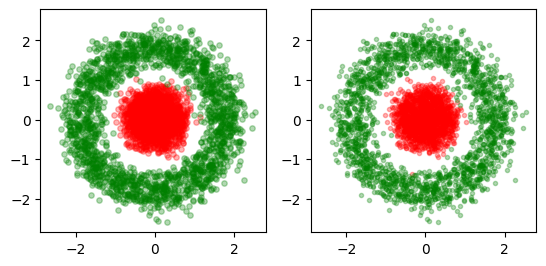

In [31]:
fig, ax = plt.subplots(1,2)
ax[0].scatter(X_test[0][T_test[0]], X_test[1][T_test[0]], c='r', alpha=0.3, s=15)
ax[0].scatter(X_test[0][T_test[1]], X_test[1][T_test[1]], c='g', alpha=0.3, s=15)
ax[0].set_aspect('equal', 'box')

ax[1].plot(X_test[0, predicted_classes == 0], X_test[1, predicted_classes == 0], '.r', alpha=0.3)
ax[1].plot(X_test[0, predicted_classes == 1], X_test[1, predicted_classes == 1], '.g', alpha=0.3)
ax[1].set_aspect('equal', 'box')

plt.show()

# MINST DATASET

In [32]:
def cross_entropy_loss(y, t):
    """
    Compute cross-entropy loss.
    
    Args:
        y (np.ndarray): Predicted probabilities, shape (num_classes, num_samples)
        t (np.ndarray): One-hot true labels, shape (num_classes, num_samples)
    
    Returns:
        float: Average cross-entropy loss
    """
    eps = 1e-10  # to avoid log(0)
    return -np.sum(t * np.log(y + eps)) / y.shape[1]

In [33]:
def batch_optimization_dynamic2(X_train, T_train, weights, lr, batch_size, epochs):
    """
    Perform batch optimization and track training and validation error.

    Returns:
        weights (list): Updated weights for each layer.
    """
    num_samples = X_train.shape[1]
    train_errors = []

    for epoch in range(epochs):
        indices = np.random.permutation(num_samples)
        X_train_shuffled = X_train[:, indices]
        T_train_shuffled = T_train[:, indices]

        for i in range(0, num_samples, batch_size):
            X_batch = X_train_shuffled[:, i:i + batch_size]
            T_batch = T_train_shuffled[:, i:i + batch_size]

            activations, outputs = forward_pass_dynamic(X_batch, weights)
            backward_pass_dynamic(X_batch, T_batch, weights, activations, outputs, lr)

        # Compute training and validation loss at the end of the epoch
        _, train_outputs = forward_pass_dynamic(X_train, weights)
        train_loss = cross_entropy_loss(train_outputs, T_train)
        train_errors.append(train_loss)

        print(f"Epoch {epoch + 1}/{epochs} completed. Training loss: {train_loss:.4f}")

    # Plot
    plt.plot(train_errors, label='Training loss')
    plt.xlabel('Epoch')
    plt.ylabel('Cross-Entropy Loss')
    plt.title('Training Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

    return weights

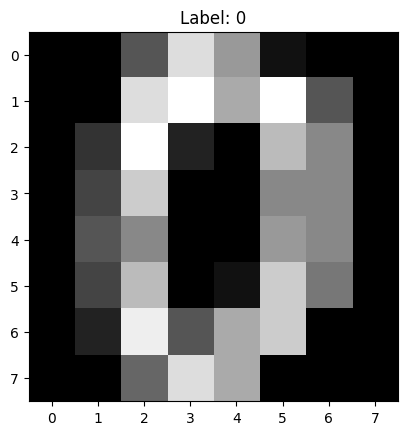

float64
(64,)
0.0
15.0
0.0
0.9375
X_digits shape: (64, 1797)
T_digits shape: (10, 1797)


In [34]:
# LOAD SKLEARN.DATASETS.LOAD_DIGITS()
from sklearn.datasets import load_digits

# Load the digits dataset
digits = load_digits()

X_digits = digits.data
y_digits = digits.target

# see one imgage
plt.imshow(X_digits[0].reshape(8, 8), cmap='gray')
plt.title(f"Label: {y_digits[0]}")
plt.show()

print(X_digits[0].dtype)
print(X_digits[0].shape)
print(X_digits[0].min())
print(X_digits[0].max())

X_digits = X_digits / 16.0  # Normalize pixel values to [0, 1]
print(X_digits[0].min())
print(X_digits[0].max())


# Reshape the data to have 64 features (8x8 images)
X_digits = X_digits.reshape(X_digits.shape[0], -1).T  # Shape: (64, num_samples)

T_digits = np.zeros((10, X_digits.shape[1]))  # One-hot encoding for 10 classes
for i in range(X_digits.shape[1]):
    T_digits[y_digits[i], i] = 1  # Set the corresponding class to 1

print("X_digits shape:", X_digits.shape)
print("T_digits shape:", T_digits.shape)

In [35]:
# Split the dataset into training and testing sets and validation sets
X_train_digits, X_test_digits, T_train_digits, T_test_digits = train_test_split(X_digits.T, T_digits.T, test_size=0.2, random_state=42)
X_train_digits = X_train_digits.T  # Transpose back to original shape
X_test_digits = X_test_digits.T    # Transpose back to original shape
T_train_digits = T_train_digits.T  # Transpose back to original shape
T_test_digits = T_test_digits.T    # Transpose back to original shape
print("Training data shape:", X_train_digits.shape)
print("Training labels shape:", T_train_digits.shape)
print("Testing data shape:", X_test_digits.shape)
print("Testing labels shape:", T_test_digits.shape)

Training data shape: (64, 1437)
Training labels shape: (10, 1437)
Testing data shape: (64, 360)
Testing labels shape: (10, 360)


Epoch 1/400 completed. Training loss: 2.5430
Epoch 2/400 completed. Training loss: 2.4372
Epoch 3/400 completed. Training loss: 2.3875
Epoch 4/400 completed. Training loss: 2.3587
Epoch 5/400 completed. Training loss: 2.3448
Epoch 6/400 completed. Training loss: 2.3353
Epoch 7/400 completed. Training loss: 2.3275
Epoch 8/400 completed. Training loss: 2.3206
Epoch 9/400 completed. Training loss: 2.3147
Epoch 10/400 completed. Training loss: 2.3086
Epoch 11/400 completed. Training loss: 2.3022
Epoch 12/400 completed. Training loss: 2.2954
Epoch 13/400 completed. Training loss: 2.2880
Epoch 14/400 completed. Training loss: 2.2803
Epoch 15/400 completed. Training loss: 2.2726
Epoch 16/400 completed. Training loss: 2.2655
Epoch 17/400 completed. Training loss: 2.2586
Epoch 18/400 completed. Training loss: 2.2517
Epoch 19/400 completed. Training loss: 2.2451
Epoch 20/400 completed. Training loss: 2.2385
Epoch 21/400 completed. Training loss: 2.2320
Epoch 22/400 completed. Training loss: 2.22

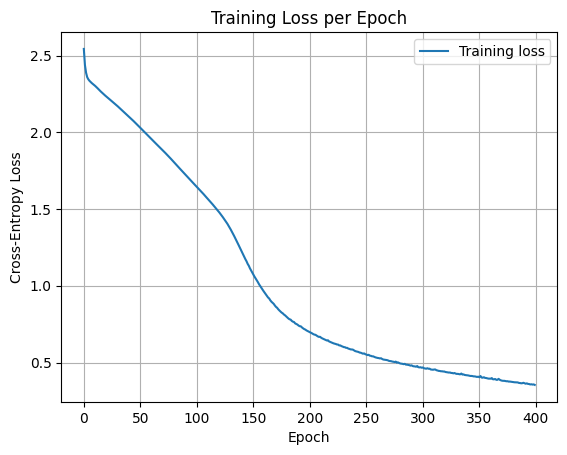

Accuracy: 86.67%


In [36]:
# Define architecture
# architecture = [X_train_digits.shape[0], 4, 8, 10, 8, 4, T_train_digits.shape[0]]  # 2 input features, 2 hidden layers, 2 output classes
architecture = [X_train_digits.shape[0], 8, 10, 8, T_train_digits.shape[0]]  # 2 input features, 2 hidden layers, 2 output classes


# Initialize weights
weights = initialize_weights_dynamic(architecture)

# Train the network
weights = batch_optimization_dynamic2(X_train_digits, T_train_digits, weights, lr=0.001, batch_size=8, epochs=400)

# Test the network
_, y_test = forward_pass_dynamic(X_test_digits, weights)

# Compute predictions
predicted_classes = np.argmax(y_test, axis=0)
real_classes = np.argmax(T_test_digits, axis=0)
accuracy = np.mean(predicted_classes == real_classes)
print(f"Accuracy: {accuracy * 100:.2f}%")

In [37]:
def plot_confusion_matrix(X, T, weights, class_names=None, title="Confusion Matrix"):
    """
    Plot the confusion matrix and compute accuracy for a classifier.

    Args:
        X (np.ndarray): Input data, shape (input_dim, num_samples).
        T (np.ndarray): True labels (one-hot), shape (num_classes, num_samples).
        weights (list): Trained weights of the model.
        class_names (list): Optional, list of class names.
        title (str): Title for the plot.
    """
    # Forward pass to get predictions
    _, outputs = forward_pass_dynamic(X, weights)
    y_pred = np.argmax(outputs, axis=0)
    y_true = np.argmax(T, axis=0)

    # Compute confusion matrix and accuracy
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc * 100:.2f}%")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"{title}\nAccuracy: {acc * 100:.2f}%")
    plt.tight_layout()
    plt.show()

Accuracy: 86.67%


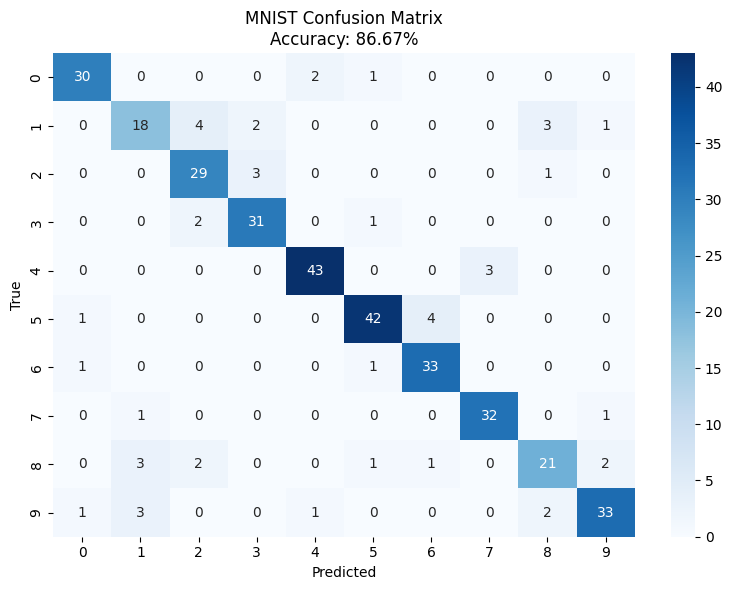

In [38]:
class_names = [str(i) for i in range(10)]
plot_confusion_matrix(X_test_digits, T_test_digits, weights, class_names=class_names, title="MNIST Confusion Matrix")

# BUGS

In [39]:
import os
from skimage import io
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.ndimage

(64, 32, 3)
uint8
255
0


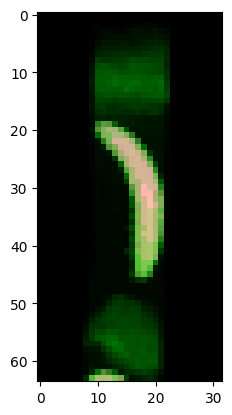

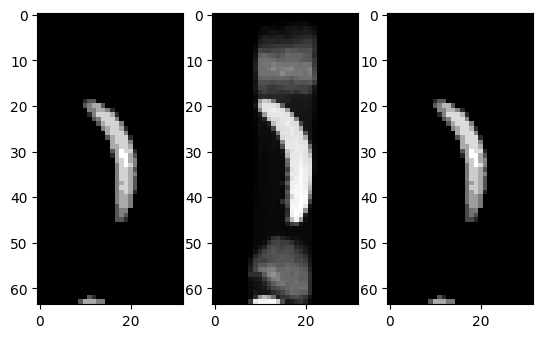

(64, 32)


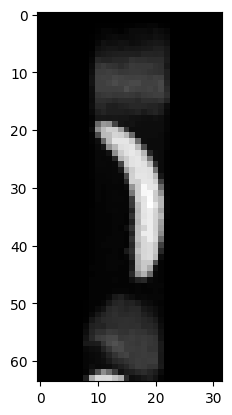

In [45]:
folder = "./data/week9_BugNIST2D_train/train/"
filename = 'bug_00000.png'
img = io.imread(os.path.join(folder, filename))
print(img.shape)
# see image type
print(img.dtype)
print(img.max())
print(img.min())
plt.figure()
plt.imshow(img, cmap='gray')

# see 3 channels of the image
plt.figure()
plt.subplot(131)
plt.imshow(img[:,:,0], cmap='gray')
plt.subplot(132)
plt.imshow(img[:,:,1], cmap='gray')
plt.subplot(133)
plt.imshow(img[:,:,2], cmap='gray')
plt.show()

# Convert to grayscale using OpenCV
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
print(img_gray.shape)  # Should be (height, width)
plt.imshow(img_gray, cmap='gray')
plt.show()


In [ ]:
def load_images_from_folder(folder):
    images = []
    for filename in sorted(os.listdir(folder)):
        img = io.imread(os.path.join(folder, filename))
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img_gray = img_gray / 255.0  # Normalize pixel values to [0, 1]
        images.append(img_gray)

    return np.array(images)

# Load images from the folder
X_images = load_images_from_folder(folder)
print(X_images.shape)  # Should be (num_images, height, width)

(28000, 64, 32)


In [ ]:
def one_hot_encode(targets, num_classes=None):
    """
    One-hot encode the target values.

    Args:
        targets (numpy.ndarray): Array of target values (integers).
        num_classes (int): Total number of classes. If None, inferred from the targets.

    Returns:
        numpy.ndarray: One-hot encoded matrix of shape (num_samples, num_classes).
    """
    if num_classes is None:
        num_classes = np.max(targets) + 1  # Infer number of classes from the targets
    one_hot = np.zeros((len(targets), num_classes))
    one_hot[np.arange(len(targets)), targets] = 1
    return one_hot

# Path to the train_targets.txt file
targets_file = '/Users/albapi/Desktop/uni/2n_sem/adv_image_analysis/code/wk09/week9_BugNIST2D_train/train_targets.txt'

# Read the targets
targets = np.loadtxt(targets_file, dtype=int)  # Assuming the targets are integers
print("Targets:", targets)
print(f"Number of targets: {len(targets)}")

# One-hot encode the targets
one_hot_targets = one_hot_encode(targets)
print("One-hot encoded targets:")
print(one_hot_targets)
print(f"Shape of one-hot encoded targets: {one_hot_targets.shape}")

Targets: [ 3 10  1 ... 11  9 10]
Number of targets: 28000
One-hot encoded targets:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
Shape of one-hot encoded targets: (28000, 12)


In [ ]:
def resize_images_to_vectors(images):
    num_images, height, width = images.shape
    return images.reshape(num_images, height * width)

# Resize images to vectors
X_vectors = resize_images_to_vectors(X_images)
print(f"Original shape: {X_images.shape}")
print(f"Resized shape: {X_vectors.shape}")

Original shape: (28000, 64, 32)
Resized shape: (28000, 2048)


In [ ]:
# Split the dataset into training and testing sets
X_train_full, X_test, T_train_full, T_test = train_test_split(
    X_vectors, one_hot_targets, test_size=0.2, random_state=42
)

# Further split the training set into training and validation sets
X_train, X_val, T_train, T_val = train_test_split(
    X_train_full, T_train_full, test_size=0.25, random_state=42
)  # 0.15 x 0.8 = 0.12 (12% of the original dataset for validation)

# Transpose back to original shape
X_train = X_train.T
X_val = X_val.T
X_test = X_test.T
T_train = T_train.T
T_val = T_val.T
T_test = T_test.T

# Print shapes of the splits
print("Training data shape:", X_train.shape)
print("Training labels shape:", T_train.shape)
print("Validation data shape:", X_val.shape)
print("Validation labels shape:", T_val.shape)
print("Testing data shape:", X_test.shape)
print("Testing labels shape:", T_test.shape)

Training data shape: (2048, 16800)
Training labels shape: (12, 16800)
Validation data shape: (2048, 5600)
Validation labels shape: (12, 5600)
Testing data shape: (2048, 5600)
Testing labels shape: (12, 5600)


In [ ]:
def augment_image(image):
    # Random horizontal flip
    if np.random.rand() > 0.5:
        image = np.fliplr(image)

    # Random rotation
    angle = np.random.uniform(-15, 15)
    image = scipy.ndimage.rotate(image, angle, reshape=False, mode='nearest')

    # Random shift
    shift = np.random.randint(-3, 4, 2)  # up to 3 pixels in each direction
    image = scipy.ndimage.shift(image, shift, mode='nearest')

    return image

In [ ]:
# Convert back to original shape: (num_samples, H, W)
X_train_original = X_train.T.reshape(-1, 64, 32)
T_train_original = T_train.T  # shape: (num_samples, num_classes)

augmented_images = []
augmented_targets = []

# Create 2 augmented versions per image
for img, label in zip(X_train_original, T_train_original):
    for _ in range(2):  # Number of augmentations per image
        augmented = augment_image(img)
        augmented_images.append(augmented)
        augmented_targets.append(label)

# Combine original and augmented
X_train_augmented = np.concatenate([X_train_original, np.array(augmented_images)])
T_train_augmented = np.concatenate([T_train_original, np.array(augmented_targets)])

print(f"Original training images: {T_train_original.shape[0]}")
print(f"Augmented training images: {T_train_augmented.shape[0]}")

Original training images: 16800
Augmented training images: 50400


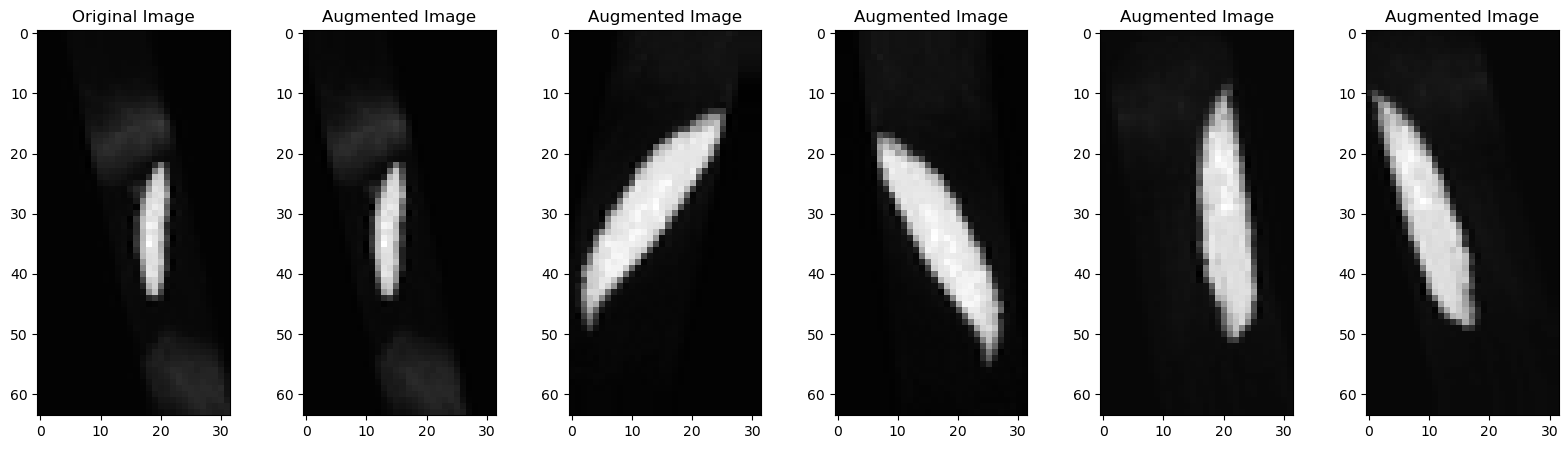

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 6, 1)
plt.imshow(X_train_augmented[0+16800], cmap='gray')
plt.title("Original Image")
plt.subplot(1, 6, 2)
plt.imshow(X_train_augmented[1+16800], cmap='gray')
plt.title("Augmented Image")
plt.subplot(1, 6, 3)
plt.imshow(X_train_augmented[2+16800], cmap='gray')
plt.title("Augmented Image")
plt.subplot(1, 6, 4)
plt.imshow(X_train_augmented[3+16800], cmap='gray')
plt.title("Augmented Image")
plt.subplot(1, 6, 5)
plt.imshow(X_train_augmented[4+16800], cmap='gray')
plt.title("Augmented Image")
plt.subplot(1, 6, 6)
plt.imshow(X_train_augmented[5+16800], cmap='gray')
plt.title("Augmented Image")
plt.show()

In [ ]:
# Resize images to vectors
X_train_aug = resize_images_to_vectors(X_train_augmented)
X_train_aug = X_train_aug.T
T_train_aug = T_train_augmented.T
print(f"Original shape: {X_train_augmented.shape}")
print(f"Resized shape: {X_train_aug.shape}")

print(f"Original shape: {T_train_augmented.shape}")
print(f"Resized shape: {T_train_aug.shape}")

Original shape: (50400, 64, 32)
Resized shape: (2048, 50400)
Original shape: (50400, 12)
Resized shape: (12, 50400)


In [ ]:
def batch_optimization_dynamic3(X_train, T_train, X_val, T_val, weights, lr, batch_size, epochs):
    """
    Perform batch optimization and track training and validation error.

    Args:
        X_train (np.ndarray): Training input data.
        T_train (np.ndarray): Training target labels.
        X_val (np.ndarray): Validation input data.
        T_val (np.ndarray): Validation target labels.
        weights (list): Initial weights of the network.
        lr (float): Learning rate.
        batch_size (int): Size of mini-batches.
        epochs (int): Number of epochs to train.

    Returns:
        weights (list): Updated weights for each layer.
    """
    num_samples = X_train.shape[1]
    train_errors = []
    val_errors = []

    for epoch in range(epochs):
        indices = np.random.permutation(num_samples)
        X_train_shuffled = X_train[:, indices]
        T_train_shuffled = T_train[:, indices]

        for i in range(0, num_samples, batch_size):
            X_batch = X_train_shuffled[:, i:i + batch_size]
            T_batch = T_train_shuffled[:, i:i + batch_size]

            activations, outputs = forward_pass_dynamic(X_batch, weights)
            backward_pass_dynamic(X_batch, T_batch, weights, activations, outputs, lr)

        # Training loss
        _, train_outputs = forward_pass_dynamic(X_train, weights)
        train_loss = cross_entropy_loss(train_outputs, T_train)
        train_errors.append(train_loss)

        # Validation loss
        _, val_outputs = forward_pass_dynamic(X_val, weights)
        val_loss = cross_entropy_loss(val_outputs, T_val)
        val_errors.append(val_loss)

        print(f"Epoch {epoch + 1}/{epochs} - Training loss: {train_loss:.4f} | Validation loss: {val_loss:.4f}")

    # Plotting
    plt.plot(train_errors, label='Training loss')
    plt.plot(val_errors, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Cross-Entropy Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

    return weights


Epoch 1/80 - Training loss: 2.5205 | Validation loss: 2.5143
Epoch 2/80 - Training loss: 2.4874 | Validation loss: 2.4797
Epoch 3/80 - Training loss: 2.4626 | Validation loss: 2.4528
Epoch 4/80 - Training loss: 2.4402 | Validation loss: 2.4283
Epoch 5/80 - Training loss: 2.4177 | Validation loss: 2.4034
Epoch 6/80 - Training loss: 2.3938 | Validation loss: 2.3761
Epoch 7/80 - Training loss: 2.3683 | Validation loss: 2.3469
Epoch 8/80 - Training loss: 2.3416 | Validation loss: 2.3166
Epoch 9/80 - Training loss: 2.3140 | Validation loss: 2.2851
Epoch 10/80 - Training loss: 2.2858 | Validation loss: 2.2525
Epoch 11/80 - Training loss: 2.2575 | Validation loss: 2.2202
Epoch 12/80 - Training loss: 2.2292 | Validation loss: 2.1879
Epoch 13/80 - Training loss: 2.2010 | Validation loss: 2.1554
Epoch 14/80 - Training loss: 2.1729 | Validation loss: 2.1228
Epoch 15/80 - Training loss: 2.1445 | Validation loss: 2.0897
Epoch 16/80 - Training loss: 2.1160 | Validation loss: 2.0566
Epoch 17/80 - Tra

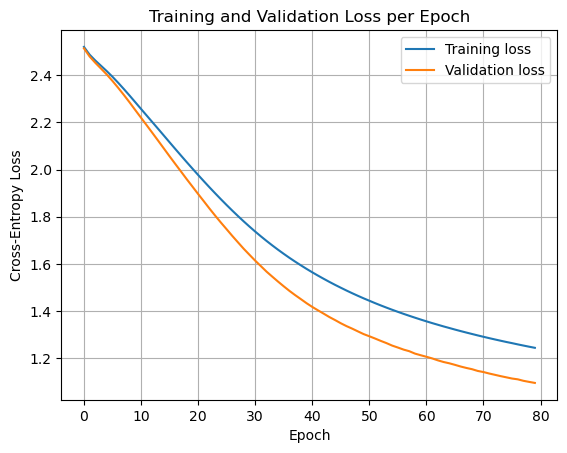

Accuracy: 63.98%


In [ ]:
# Define architecture
# architecture = [X_train_digits.shape[0], 4, 8, 10, 8, 4, T_train_digits.shape[0]]  # 2 input features, 2 hidden layers, 2 output classes
architecture = [X_train.shape[0], 28, 28, 28, T_train.shape[0]]
#architecture = [X_train.shape[1], 128, 64, T_train.shape[1]]

# Initialize weights
weights = initialize_weights_dynamic(architecture)

# Train the network
weights = batch_optimization_dynamic3(X_train_aug, T_train_aug, X_val, T_val, weights, lr=0.0001, batch_size=32, epochs=80)

# Test the network
_, y_test = forward_pass_dynamic(X_test, weights)

# Compute predictions
predicted_classes = np.argmax(y_test, axis=0)
real_classes = np.argmax(T_test, axis=0)
accuracy = np.mean(predicted_classes == real_classes)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 72.82%


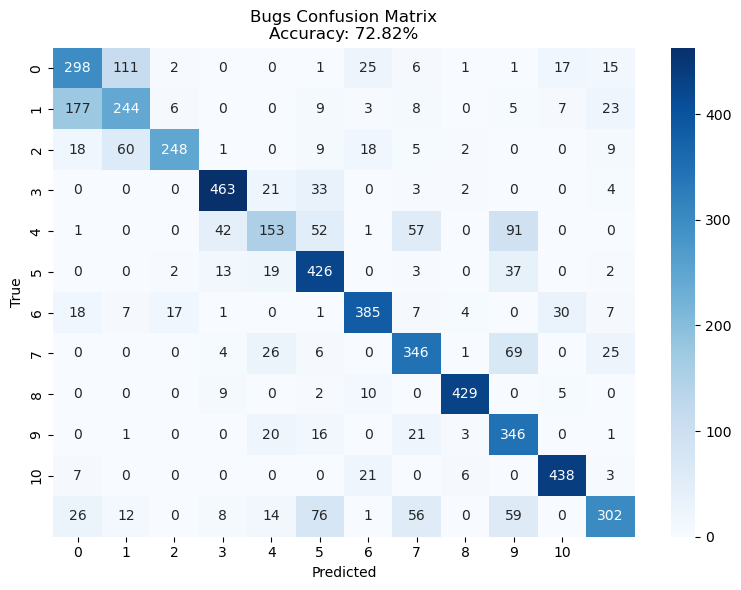

In [ ]:
class_names = [str(i) for i in range(11)]
plot_confusion_matrix(X_test, T_test, weights, class_names=class_names, title="Bugs Confusion Matrix")

cosas
- guardar el modelo cuando lo haga bien, y empezar a entrenarlo con el guardado
